### Description

1. Sample a selection of the dataset of compounds and get all unique BBs at each position. 
2. Calculate P(active) values for each building block.
3. Generate similarity matrix for the BBs at each position.
4. Map coordinates with UMAP, cluster with HDBSCAN.
5. Aggregate and identify strong cluster pairings
6. Add in holdout set points
7. Predict holdout BB activity and discard undesirable BBs
8. Propose new compounds based on cluster groupings
9. Evaluate active identification rate vs random sampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
import umap
import hdbscan
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    precision_score, recall_score, precision_recall_curve, pairwise_distances

%matplotlib inline

### Step 1: Sample a selection of compounds and get all unique BBs at each position

In [2]:
total_compounds = pd.read_csv('../data_preparation/output/total_compounds.csv')
bb1 = pd.read_csv('../data_preparation/output/bb1_pactive.csv')
bb1_ = bb1.drop(columns='P(active)').rename(columns={'SMILES': 'bb1'})
bb2 = pd.read_csv('../data_preparation/output/bb2_pactive.csv')
bb2_ = bb2.drop(columns='P(active)').rename(columns={'SMILES': 'bb2'})
bb3 = pd.read_csv('../data_preparation/output/bb3_pactive.csv')
bb3_ = bb3.drop(columns='P(active)').rename(columns={'SMILES': 'bb3'})

# We cannot generate conformers for this building block
total_compounds = total_compounds.loc[total_compounds['bb3'] != 'NC1[C@H]2CC3C[C@H]1CC(O)(C3)C2']
total_compounds['active'] = [1 if x > 0 else 0 for x in total_compounds['read_count']]
# print(len(total_compounds))
# display(total_compounds.head(5))

### Holdout 5% of unique BBs from each position (and all the corresponding compounds)

In [3]:
## Selectively holdout X% of BBs from each unique position
seed = 2
bb1_train = bb1_.sample(frac=0.95, replace=False, random_state=seed)
bb2_train = bb2_.sample(frac=0.95, replace=False, random_state=seed)
bb3_train = bb3_.sample(frac=0.95, replace=False, random_state=seed)

In [4]:
## Get BBs from the holdout set
a = pd.merge(bb1_, bb1_train, how='left', indicator=True)
bb1_test = a.loc[a['_merge'] == 'left_only'].drop(columns=['_merge'])

b = pd.merge(bb2_, bb2_train, how='left', indicator=True)
bb2_test = b.loc[b['_merge'] == 'left_only'].drop(columns=['_merge'])

c = pd.merge(bb3_, bb3_train, how='left', indicator=True)
bb3_test = c.loc[c['_merge'] == 'left_only'].drop(columns=['_merge'])

In [5]:
# structure | read_count | bb1 | bb2 | bb3 | active
training = total_compounds.merge(bb1_train['bb1'], on='bb1').merge(bb2_train['bb2'], on='bb2').merge(bb3_train['bb3'], on='bb3')
#print(len(training))

In [6]:
# structure | read_count | bb1 | bb2 | bb3 | active
itd = pd.merge(total_compounds, training['structure'], how='left', on='structure', indicator=True)
testing = itd.loc[itd['_merge'] == 'left_only'].drop(columns='_merge')
#print(len(testing))

In [7]:
bb1

,SMILES,P(active),stereo_SMILES
0,C(C#N)[C@H](C(=O)O)N,0.000000,C(C#N)[C@H](C(=O)O)N
1,C(C(=O)O)N,0.000687,C(C(=O)O)N
2,C(C(C(=O)O)N)C(=O)N,0.000000,C([C@@H](C(=O)O)N)C(=O)N
3,C(CC(=O)N)[C@@H](C(=O)O)N,0.003900,C(CC(=O)N)[C@@H](C(=O)O)N
4,C(CC(=O)O)CN,0.003656,C(CC(=O)O)CN
...,...,...,...
640,c1cnccc1C[C@H](C(=O)O)N,0.000000,c1cnccc1C[C@H](C(=O)O)N
641,c1cnn(c1C(=O)O)CC2CNC2,0.000000,c1cnn(c1C(=O)O)CC2CNC2
642,c1nc(c(o1)C2CNCCO2)C(=O)O,0.000089,c1nc(c(o1)[C@@H]2CNCCO2)C(=O)O
643,c1nc(nn1CC2CCNCC2)C(=O)O,0.000000,c1nc(nn1CC2CCNCC2)C(=O)O


In [8]:
bb1_test_ans = pd.merge(bb1[['SMILES', 'P(active)']], bb1_test, left_on='SMILES', right_on='bb1')
bb2_test_ans = pd.merge(bb2[['SMILES', 'P(active)']], bb2_test, left_on='SMILES', right_on='bb2')
bb3_test_ans = pd.merge(bb3[['SMILES', 'P(active)']], bb3_test, left_on='SMILES', right_on='bb3')

#### 2. Calculate P(active) values for each building block

In [9]:
bb1_p = training.groupby(['bb1'], as_index=False)['active'].mean()
itd = pd.merge(bb1_, bb1_p, on='bb1', how='left', indicator=True)
bb1_pactive = itd.loc[itd['_merge'] == 'both'].drop(columns=['stereo_SMILES', '_merge'])
#bb1_pactive['bb1_bins'] = pd.cut(bb1_pactive['active'], bins=4, labels=np.arange(0,4))
#bb1_pactive['bb1_bins'] = [int(x) for x in bb1_pactive['bb1_bins']]
bb1_pactive = bb1_pactive.rename(columns={'active': 'P(active)_1'})

bb2_p = training.groupby(['bb2'], as_index=False)['active'].mean()
itd = pd.merge(bb2_, bb2_p, on='bb2', how='left', indicator=True)
bb2_pactive = itd.loc[itd['_merge'] == 'both'].drop(columns=['stereo_SMILES', '_merge'])
#bb2_pactive['bb2_bins'] = pd.cut(bb2_pactive['active'], bins=4, labels=np.arange(0,4))
#bb2_pactive['bb2_bins'] = [int(x) for x in bb2_pactive['bb2_bins']]
bb2_pactive = bb2_pactive.rename(columns={'active': 'P(active)_2'})

bb3_p = training.groupby(['bb3'], as_index=False)['active'].mean()
itd = pd.merge(bb3_, bb3_p, on='bb3', how='left', indicator=True)
bb3_pactive = itd.loc[itd['_merge'] == 'both'].drop(columns=['stereo_SMILES', '_merge'])
#bb3_pactive['bb3_bins'] = pd.cut(bb3_pactive['active'], bins=4, labels=np.arange(0,4))
#bb3_pactive['bb3_bins'] = [int(x) for x in bb3_pactive['bb3_bins']]
bb3_pactive = bb3_pactive.rename(columns={'active': 'P(active)_3'})

### Can we predict the activity of new combinations based on existing data?

1. Sample a selection of the dataset of compounds and get all unique BBs at each position. 
2. Calculate P(active) values for each building block.
3. Generate similarity matrix for the BBs at each position.
4. Map coordinates with UMAP, cluster with HDBSCAN.
5. Aggregate and identify strong cluster pairings
6. Predict activity of compounds from the holdout set

#### 3. Generate similarity matrix for BBs at each position

In [10]:
bb1_sim_3D = np.load('../data_preparation/output/bb1_info.npy')
bb1_dist_3D = 2 - (bb1_sim_3D + bb1_sim_3D.T)/2 
np.fill_diagonal(bb1_dist_3D, 0)

bb2_sim_3D = np.load('../data_preparation/output/bb2_info.npy')
bb2_dist_3D = 2 - (bb2_sim_3D + bb2_sim_3D.T)/2 
np.fill_diagonal(bb2_dist_3D, 0)

bb3_sim_3D = np.load('../data_preparation/output/bb3_info.npy')
bb3_dist_3D = 2 - (bb3_sim_3D + bb3_sim_3D.T)/2 
np.fill_diagonal(bb3_dist_3D, 0)

In [11]:
bb1_train_ind = list(bb1_pactive.index)
bb1_test_ind = list(bb1_test.index)

bb2_train_ind = list(bb2_pactive.index)
bb2_test_ind = list(bb2_test.index)

bb3_train_ind = list(bb3_pactive.index)
bb3_test_ind = list(bb3_test.index)

#### 4. Map coordinates with UMAP, cluster with HDBSCAN

In [12]:
U_bb1 = umap.UMAP(random_state=0, metric='precomputed')
U_bb2 = umap.UMAP(random_state=0, metric='precomputed')
U_bb3 = umap.UMAP(random_state=0, metric='precomputed')

#trans_bb1 = U_bb1.fit(bb1_2D_dist)
#trans_bb2 = U_bb2.fit(bb2_2D_dist)
#trans_bb3 = U_bb3.fit(bb3_2D_dist)
trans_bb1 = U_bb1.fit(bb1_dist_3D[bb1_train_ind, :][:, bb1_train_ind])
trans_bb2 = U_bb2.fit(bb2_dist_3D[bb2_train_ind, :][:, bb2_train_ind])
trans_bb3 = U_bb3.fit(bb3_dist_3D[bb3_train_ind, :][:, bb3_train_ind])

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [13]:
bb1_pactive['X'] = trans_bb1.embedding_[:, 0]
bb1_pactive['Y'] = trans_bb1.embedding_[:, 1]

bb2_pactive['X'] = trans_bb2.embedding_[:, 0]
bb2_pactive['Y'] = trans_bb2.embedding_[:, 1]

bb3_pactive['X'] = trans_bb3.embedding_[:, 0]
bb3_pactive['Y'] = trans_bb3.embedding_[:, 1]

In [14]:
# fig, axs = plt.subplots(1, 3, figsize=(18,6))
# axs[0].scatter(trans_bb1.embedding_[:, 0], trans_bb1.embedding_[:, 1], s=10)
# axs[0].set_title('UMAP embedding of BB1 training set')

# axs[1].scatter(trans_bb2.embedding_[:, 0], trans_bb2.embedding_[:, 1], s=10)
# axs[1].set_title('UMAP embedding of BB2 training set')

# axs[2].scatter(trans_bb3.embedding_[:, 0], trans_bb3.embedding_[:, 1], s=10)
# axs[2].set_title('UMAP embedding of BB3 training set')
# plt.show()

In [15]:
# def set_colors(cluster_labels):
#     # Make color for noise points gray if they exist
#     if np.sum(cluster_labels == -1) > 0:
#         color = plt.cm.rainbow(np.linspace(0, 1, len(set(cluster_labels))-1))
#         colors = np.vstack([color, [0.86, 0.86, 0.86, 1]])
#         return colors
#     # Otherwise generate a normal colormap for the range of all cluster ids
#     else:
#         color = plt.cm.rainbow(np.linspace(0, 1, len(set(cluster_labels))))
#         return color

In [16]:
from sklearn.metrics import pairwise_distances

def intracluster_dist(df):
    dist_mat = pairwise_distances(df[['X', 'Y']])
    N = len(dist_mat)
    ind = np.triu_indices(N, k=1)
    return np.mean(dist_mat[ind])

def optimal_hdbscan(df):
    BB = df.copy(deep=True)
    hdb_params = pd.DataFrame(columns=['min_cluster_size', 'min_samples', 'n_noise', 'icd'])
    for i in np.arange(3,61):
        for j in np.arange(1,21):
            if i <= j:
                pass
            else:
                info = {}
                coords = BB[['X', 'Y']].to_numpy()
                cluster = hdbscan.HDBSCAN(min_cluster_size=int(i), min_samples=int(j), metric='euclidean', gen_min_span_tree=True, 
                                  allow_single_cluster=False).fit(coords)

                BB['Cluster'] = cluster.labels_
                info['min_cluster_size'] = int(i)
                info['min_samples'] = int(j)
                info['n_noise'] = len(BB.loc[BB['Cluster'] == -1])
                
                g = BB.groupby('Cluster')
                h = g.apply(intracluster_dist).reset_index(name='dist')
                info['icd'] = np.mean(h.loc[h['Cluster'] > -1, 'dist'])

                hdb_params = hdb_params.append(info, ignore_index=True)
    return hdb_params

def obj(n_noise, icd):
    return n_noise + 10*icd

#### Find optimal HDBSCAN parameters for BB1

In [17]:
bb1_params = optimal_hdbscan(bb1_pactive)
bb1_ind = np.argmin(obj(bb1_params['n_noise'], bb1_params['icd']))
bb1_optimal = bb1_params.iloc[bb1_ind]

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/e

In [18]:
# print(bb1_optimal)
# plt.plot(obj(bb1_params['n_noise'], bb1_params['icd']))

In [19]:
# fig, axs = plt.subplots(figsize=(5,5), dpi=150)
bb1_cluster = hdbscan.HDBSCAN(min_cluster_size=int(bb1_optimal['min_cluster_size']), min_samples=int(bb1_optimal['min_samples']), 
                                metric='euclidean', gen_min_span_tree=True, 
                          allow_single_cluster=False, prediction_data=True).fit(trans_bb1.embedding_)

# bb1_cluster_colors = set_colors(bb1_cluster.labels_)

# axs.scatter(trans_bb1.embedding_[:, 0], trans_bb1.embedding_[:, 1], color=bb1_cluster_colors[bb1_cluster.labels_], s=10)
# axs.set_title(f'Number of Clusters: {len(np.unique(bb1_cluster.labels_))-1}\nNoise points: {np.unique(bb1_cluster.labels_, return_counts=True)[1][0]}')

# #axs[1].scatter(trans_bb1.embedding_[:, 0], trans_bb1.embedding_[:, 1], color=bb1_cluster_b_colors[bb1_cluster_b.labels_], s=10)
# #axs[1].set_title(f'Number of Clusters: {len(np.unique(bb1_cluster_b.labels_))-1}\nNoise points: {np.unique(bb1_cluster_b.labels_, return_counts=True)[1][0]}')

# plt.show()

In [20]:
bb1_pactive['bb1_Cluster'] = bb1_cluster.labels_

#### Predict which cluster each holdout BB belongs to

In [21]:
# fig, axs = plt.subplots(1, 2, figsize=(12,6), dpi=150)

# bb1_cluster_colors = set_colors(bb1_cluster.labels_)

# axs[0].scatter(trans_bb1.embedding_[:, 0], trans_bb1.embedding_[:, 1], color=bb1_cluster_colors[bb1_cluster.labels_], s=10)
# axs[0].set_title(f'Number of Clusters: {len(np.unique(bb1_cluster.labels_))-1}\nNoise points: {np.unique(bb1_cluster.labels_, return_counts=True)[1][0]}')

# # Project holdout BBs to the existing coordinate system
bb1_test_coords = trans_bb1.transform(bb1_dist_3D[np.ix_(bb1_test_ind, bb1_train_ind)])
# axs[0].scatter(bb1_test_coords[:, 0], bb1_test_coords[:, 1], color='black', s=20)

# # Predict cluster assignment for each holdout building block
bb1_test_cluster_, bb1_test_prob_ = hdbscan.prediction.approximate_predict(bb1_cluster, bb1_test_coords)
# axs[1].scatter(trans_bb1.embedding_[:, 0], trans_bb1.embedding_[:, 1], color=bb1_cluster_colors[bb1_cluster.labels_], alpha=0.4, s=5)
# axs[1].scatter(bb1_test_coords[:, 0], bb1_test_coords[:, 1], color=bb1_cluster_colors[bb1_test_cluster_], s=20, edgecolor='black')
# axs[1].set_title(f'Classification of Holdout BBs: {len(np.where(bb1_test_cluster_ > -1)[0])}/{len(bb1_test_cluster_)} classified')
# plt.show()

# Assign cluster assignment to each holdout BB
bb1_test['bb1_Cluster'] = bb1_test_cluster_

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:2831: UserWarning: Transforming new data with precomputed metric. We are assuming the input data is a matrix of distances from the new points to the points in the training set. If the input matrix is sparse, it should contain distances from the new points to their nearest neighbours or approximate nearest neighbours in the training set.
  "Transforming new data with precomputed metric. "


In [22]:
def get_nn_pactive_bb1(bb1_id):
    bb = bb1_test.loc[bb1_id]
    # get BB id
    bb_id = bb.name
    # get cluster id
    cluster_id = bb['bb1_Cluster']
    # get ids of all BBs in the assigned cluster
    cluster_bb_ids = list(bb1_pactive.loc[bb1_pactive['bb1_Cluster'] == cluster_id].index)
    ind = np.ix_([bb_id], cluster_bb_ids)
    # find nearest neighbor of unknown BB from the assigned cluster
    nn_ind = np.argmin(bb1_dist_3D[ind])
    cluster_nn_ind = cluster_bb_ids[nn_ind]
    return bb1_pactive.loc[cluster_nn_ind]['P(active)_1']

#### Predict activity of BB based on cluster it was assigned to

In [23]:
np.random.seed(10)
cluster_med = [np.median(bb1_pactive.loc[bb1_pactive['bb1_Cluster'] == x, 'P(active)_1']) for x in bb1_test['bb1_Cluster']]
cluster_mean = [np.mean(bb1_pactive.loc[bb1_pactive['bb1_Cluster'] == x, 'P(active)_1']) for x in bb1_test['bb1_Cluster']]
cluster_rand = [bb1_pactive.loc[bb1_pactive['bb1_Cluster'] == x, 'P(active)_1'].sample(n=1).values[0] for x in bb1_test['bb1_Cluster']]
cluster_nn = [get_nn_pactive_bb1(bb_id) for bb_id in bb1_test.index]
random_pred = [bb1_pactive['P(active)_1'].sample(n=1).values[0] for x in range(len(bb1_test))]

bb1_test['pactive_med'] = cluster_med
bb1_test['pactive_mean'] = cluster_mean
bb1_test['pactive_crand'] = cluster_rand
bb1_test['pactive_nn'] = cluster_nn
bb1_test['random'] = random_pred

#### Repeat for BB2

In [24]:
bb2_params = optimal_hdbscan(bb2_pactive)
bb2_ind = np.argmin(obj(bb2_params['n_noise'], bb2_params['icd']))
bb2_optimal = bb2_params.iloc[bb2_ind]

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/e

In [25]:
#print(bb2_optimal)
#plt.plot(obj(bb2_params['n_noise'], bb2_params['icd']))

In [26]:
#fig, axs = plt.subplots(figsize=(5,5), dpi=150)
bb2_cluster = hdbscan.HDBSCAN(min_cluster_size=int(bb2_optimal['min_cluster_size']), min_samples=int(bb2_optimal['min_samples']), 
                                metric='euclidean', gen_min_span_tree=True, 
                          allow_single_cluster=False, prediction_data=True).fit(trans_bb2.embedding_)

#bb2_cluster_colors = set_colors(bb2_cluster.labels_)

#axs.scatter(trans_bb2.embedding_[:, 0], trans_bb2.embedding_[:, 1], color=bb2_cluster_colors[bb2_cluster.labels_], s=10)
#axs.set_title(f'Number of Clusters: {len(np.unique(bb2_cluster.labels_))-1}\nNoise points: {np.unique(bb2_cluster.labels_, return_counts=True)[1][0]}')

#axs[1].scatter(trans_bb2.embedding_[:, 0], trans_bb2.embedding_[:, 1], color=bb2_cluster_b_colors[bb2_cluster_b.labels_], s=10)
#axs[1].set_title(f'Number of Clusters: {len(np.unique(bb2_cluster_b.labels_))-1}\nNoise points: {np.unique(bb2_cluster_b.labels_, return_counts=True)[1][0]}')

plt.show()

In [27]:
bb2_pactive['bb2_Cluster'] = bb2_cluster.labels_

#### Predict which cluster each new BB belongs to

In [28]:
#fig, axs = plt.subplots(1, 2, figsize=(12,6), dpi=150)

#bb2_cluster_colors = set_colors(bb2_cluster.labels_)

#axs[0].scatter(trans_bb2.embedding_[:, 0], trans_bb2.embedding_[:, 1], color=bb2_cluster_colors[bb2_cluster.labels_], s=10)
#axs[0].set_title(f'Number of Clusters: {len(np.unique(bb2_cluster.labels_))-1}\nNoise points: {np.unique(bb2_cluster.labels_, return_counts=True)[1][0]}')

# Project holdout BBs to the existing coordinate system
bb2_test_coords = trans_bb2.transform(bb2_dist_3D[np.ix_(bb2_test_ind, bb2_train_ind)])
#axs[0].scatter(bb2_test_coords[:, 0], bb2_test_coords[:, 1], color='black', s=20)

# Predict cluster assignment for each holdout building block
bb2_test_cluster_, bb2_test_prob_ = hdbscan.prediction.approximate_predict(bb2_cluster, bb2_test_coords)
#axs[1].scatter(trans_bb2.embedding_[:, 0], trans_bb2.embedding_[:, 1], color=bb2_cluster_colors[bb2_cluster.labels_], alpha=0.4, s=5)
#axs[1].scatter(bb2_test_coords[:, 0], bb2_test_coords[:, 1], color=bb2_cluster_colors[bb2_test_cluster_], s=20, edgecolor='black')
#axs[1].set_title(f'Classification of Holdout BBs: {len(np.where(bb2_test_cluster_ > -1)[0])}/{len(bb2_test_cluster_)} classified')
#plt.show()

# Assign cluster assignment to each holdout BB
bb2_test['bb2_Cluster'] = bb2_test_cluster_

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:2831: UserWarning: Transforming new data with precomputed metric. We are assuming the input data is a matrix of distances from the new points to the points in the training set. If the input matrix is sparse, it should contain distances from the new points to their nearest neighbours or approximate nearest neighbours in the training set.
  "Transforming new data with precomputed metric. "


In [29]:
def get_nn_pactive_bb2(bb2_id):
    bb = bb2_test.loc[bb2_id]
    # get BB id
    bb_id = bb.name
    # get cluster id
    cluster_id = bb['bb2_Cluster']
    # get ids of all BBs in the assigned cluster
    cluster_bb_ids = list(bb2_pactive.loc[bb2_pactive['bb2_Cluster'] == cluster_id].index)
    ind = np.ix_([bb_id], cluster_bb_ids)
    # find nearest neighbor of unknown BB from the assigned cluster
    nn_ind = np.argmin(bb2_dist_3D[ind])
    cluster_nn_ind = cluster_bb_ids[nn_ind]
    return bb2_pactive.loc[cluster_nn_ind]['P(active)_2']

#### Predict activity of BB based on cluster it was assigned to

In [30]:
np.random.seed(10)
cluster_med = [np.median(bb2_pactive.loc[bb2_pactive['bb2_Cluster'] == x, 'P(active)_2']) for x in bb2_test['bb2_Cluster']]
cluster_mean = [np.mean(bb2_pactive.loc[bb2_pactive['bb2_Cluster'] == x, 'P(active)_2']) for x in bb2_test['bb2_Cluster']]
cluster_rand = [bb2_pactive.loc[bb2_pactive['bb2_Cluster'] == x, 'P(active)_2'].sample(n=1).values[0] for x in bb2_test['bb2_Cluster']]
cluster_nn = [get_nn_pactive_bb2(bb_id) for bb_id in bb2_test.index]
random_pred = [bb2_pactive['P(active)_2'].sample(n=1).values[0] for x in range(len(bb2_test))]


bb2_test['pactive_med'] = cluster_med
bb2_test['pactive_mean'] = cluster_mean
bb2_test['pactive_crand'] = cluster_rand
bb2_test['pactive_nn'] = cluster_nn
bb2_test['random'] = random_pred

#### Repeat for BB3

In [31]:
bb3_params = optimal_hdbscan(bb3_pactive)
bb3_ind = np.argmin(obj(bb3_params['n_noise'], bb3_params['icd']))
bb3_optimal = bb3_params.iloc[bb3_ind]

In [32]:
# print(bb3_optimal)
# plt.plot(obj(bb3_params['n_noise'], bb3_params['icd']))

In [33]:
#fig, axs = plt.subplots(figsize=(5,5), dpi=150)
bb3_cluster = hdbscan.HDBSCAN(min_cluster_size=int(bb3_optimal['min_cluster_size']), min_samples=int(bb3_optimal['min_samples']), 
                                metric='euclidean', gen_min_span_tree=True, 
                          allow_single_cluster=False, prediction_data=True).fit(trans_bb3.embedding_)

#bb3_cluster_colors = set_colors(bb3_cluster.labels_)

#axs.scatter(trans_bb3.embedding_[:, 0], trans_bb3.embedding_[:, 1], color=bb3_cluster_colors[bb3_cluster.labels_], s=10)
#axs.set_title(f'Number of Clusters: {len(np.unique(bb3_cluster.labels_))-1}\nNoise points: {np.unique(bb3_cluster.labels_, return_counts=True)[1][0]}')

#axs[1].scatter(trans_bb3.embedding_[:, 0], trans_bb3.embedding_[:, 1], color=bb3_cluster_b_colors[bb3_cluster_b.labels_], s=10)
#axs[1].set_title(f'Number of Clusters: {len(np.unique(bb3_cluster_b.labels_))-1}\nNoise points: {np.unique(bb3_cluster_b.labels_, return_counts=True)[1][0]}')

plt.show()

In [34]:
bb3_pactive['bb3_Cluster'] = bb3_cluster.labels_

#### Predict which clusters new building blocks belong to

In [35]:
#fig, axs = plt.subplots(1, 2, figsize=(12,6), dpi=150)

#bb3_cluster_colors = set_colors(bb3_cluster.labels_)

#axs[0].scatter(trans_bb3.embedding_[:, 0], trans_bb3.embedding_[:, 1], color=bb3_cluster_colors[bb3_cluster.labels_], s=10)
#axs[0].set_title(f'Number of Clusters: {len(np.unique(bb3_cluster.labels_))-1}\nNoise points: {np.unique(bb3_cluster.labels_, return_counts=True)[1][0]}')

# Project holdout BBs to the existing coordinate system
bb3_test_coords = trans_bb3.transform(bb3_dist_3D[np.ix_(bb3_test_ind, bb3_train_ind)])
#axs[0].scatter(bb3_test_coords[:, 0], bb3_test_coords[:, 1], color='black', s=20)

# Predict cluster assignment for each holdout building block
bb3_test_cluster_, bb3_test_prob_ = hdbscan.prediction.approximate_predict(bb3_cluster, bb3_test_coords)
#axs[1].scatter(trans_bb3.embedding_[:, 0], trans_bb3.embedding_[:, 1], color=bb3_cluster_colors[bb3_cluster.labels_], alpha=0.4, s=5)
#axs[1].scatter(bb3_test_coords[:, 0], bb3_test_coords[:, 1], color=bb3_cluster_colors[bb3_test_cluster_], s=20, edgecolor='black')
#axs[1].set_title(f'Classification of Holdout BBs: {len(np.where(bb3_test_cluster_ > -1)[0])}/{len(bb3_test_cluster_)} classified')
#plt.show()

# Assign cluster assignment to each holdout BB
bb3_test['bb3_Cluster'] = bb3_test_cluster_

/opt/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/umap/umap_.py:2831: UserWarning: Transforming new data with precomputed metric. We are assuming the input data is a matrix of distances from the new points to the points in the training set. If the input matrix is sparse, it should contain distances from the new points to their nearest neighbours or approximate nearest neighbours in the training set.
  "Transforming new data with precomputed metric. "


In [36]:
def get_nn_pactive_bb3(bb3_id):
    bb = bb3_test.loc[bb3_id]
    # get BB id
    bb_id = bb.name
    # get cluster id
    cluster_id = bb['bb3_Cluster']
    # get ids of all BBs in the assigned cluster
    cluster_bb_ids = list(bb3_pactive.loc[bb3_pactive['bb3_Cluster'] == cluster_id].index)
    ind = np.ix_([bb_id], cluster_bb_ids)
    # find nearest neighbor of unknown BB from the assigned cluster
    nn_ind = np.argmin(bb3_dist_3D[ind])
    cluster_nn_ind = cluster_bb_ids[nn_ind]
    return bb3_pactive.loc[cluster_nn_ind]['P(active)_3']

In [37]:
np.random.seed(10)
cluster_med = [np.median(bb3_pactive.loc[bb3_pactive['bb3_Cluster'] == x, 'P(active)_3']) for x in bb3_test['bb3_Cluster']]
cluster_mean = [np.mean(bb3_pactive.loc[bb3_pactive['bb3_Cluster'] == x, 'P(active)_3']) for x in bb3_test['bb3_Cluster']]
cluster_rand = [bb3_pactive.loc[bb3_pactive['bb3_Cluster'] == x, 'P(active)_3'].sample(n=1).values[0] for x in bb3_test['bb3_Cluster']]
cluster_nn = [get_nn_pactive_bb3(bb_id) for bb_id in bb3_test.index]
random_pred = [bb3_pactive['P(active)_3'].sample(n=1).values[0] for x in range(len(bb3_test))]

bb3_test['pactive_med'] = cluster_med
bb3_test['pactive_mean'] = cluster_mean
bb3_test['pactive_crand'] = cluster_rand
bb3_test['pactive_nn'] = cluster_nn
bb3_test['random'] = random_pred


### Clustering information: look at trends across all clustered BBs

In [38]:
# clustered_bb1 = bb1_pactive.loc[bb1_pactive['bb1_Cluster'] > -1]
# clustered_bb2 = bb2_pactive.loc[bb2_pactive['bb2_Cluster'] > -1]
# clustered_bb3 = bb3_pactive.loc[bb3_pactive['bb3_Cluster'] > -1]

training_merged = training.merge(bb1_pactive, on='bb1').merge(bb2_pactive, on='bb2').merge(bb3_pactive, on='bb3')
#training_merged

In [39]:
# from IPython.display import display_html
# from itertools import chain,cycle
# def display_side_by_side(*args,titles=cycle([''])):
#     html_str=''
#     for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
#         html_str+='<th style="text-align:center"><td style="vertical-align:top">'
#         html_str+=f'<h2 style="text-align: center;">{title}</h2>'
#         html_str+=df.to_html().replace('table','table style="display:inline"')
#         html_str+='</td></th>'
#     display_html(html_str,raw=True)

In [40]:
# # Return the top trisynthon cluster combinations by active rate and number of structures
# abc = training_merged.groupby(['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster'], as_index=False)\
#     .agg({'active': 'mean',
#           'structure': 'count'})

# #abc.sort_values(by='active', ascending=False).head(10)

In [41]:
# ab = training_merged.groupby(['bb1_Cluster', 'bb2_Cluster'], as_index=False)\
#     .agg({'active': 'mean',
#          'structure': 'count'})
# #top_ab = ab.sort_values(by='active', ascending=False).head(10)

# bc = training_merged.groupby(['bb2_Cluster', 'bb3_Cluster'], as_index=False)\
#     .agg({'active': 'mean',
#           'structure': 'count'})
# #top_bc = bc.sort_values(by='active', ascending=False).head(10)

# ac = training_merged.groupby(['bb1_Cluster', 'bb3_Cluster'], as_index=False)\
#     .agg({'active': 'mean',
#           'structure': 'count'})
# #top_ac = ac.sort_values(by='active', ascending=False).head(10)

# #display_side_by_side(top_ab, top_bc, top_ac, titles=['AB','BC', 'AC'])

In [42]:
# import seaborn as sns
# n_bb1 = len(np.unique(bb1_pactive['bb1_Cluster']))-1
# n_bb2 = len(np.unique(bb2_pactive['bb2_Cluster']))-1
# n_bb3 = len(np.unique(bb3_pactive['bb3_Cluster']))-1
# ab_mat = np.ones((n_bb1, n_bb2))*-0.05
# for b1, b2, val in zip(ab['bb1_Cluster'], ab['bb2_Cluster'], ab['active']):
#     ab_mat[b1, b2] = val

# ac_mat = np.ones((n_bb1, n_bb3))*-0.05
# for b1, b3, val in zip(ac['bb1_Cluster'], ac['bb3_Cluster'], ac['active']):
#     ac_mat[b1, b3] = val
    
# bc_mat = np.ones((n_bb2, n_bb3))*-0.05
# for b2, b3, val in zip(bc['bb2_Cluster'], bc['bb3_Cluster'], bc['active']):
#     bc_mat[b2, b3] = val
    
# cb_mat = np.ones((n_bb3, n_bb2))*-0.05
# for b2, b3, val in zip(bc['bb2_Cluster'], bc['bb3_Cluster'], bc['active']):
#     cb_mat[b3, b2] = val

In [43]:
# fig, axs = plt.subplots(1, 3, figsize=(18,6), dpi=150)
# plt.subplots_adjust(wspace=0.3)
# val_max = np.max(np.concatenate([ab['active'], ac['active'], bc['active']]))

# M = 5
# cbar_ax = fig.add_axes([.92, .12, .015, .76])
# ax = sns.heatmap(ab_mat, vmin=-0.05, vmax=val_max, ax=axs[0], cmap='viridis', cbar_ax=cbar_ax,)
# axs[0].set_xticks(np.arange(0.5, n_bb2+0.5))
# axs[0].set_xticklabels(np.arange(n_bb2), fontsize=14)
# axs[0].set_yticks(np.arange(0.5, n_bb1+0.5))
# axs[0].set_yticklabels(np.arange(n_bb1), fontsize=14, rotation=0)
# axs[0].set_ylabel('bb1 Cluster', fontsize=18, labelpad=10)
# axs[0].set_xlabel('bb2 Cluster', fontsize=18, labelpad=10)

# sns.heatmap(ac_mat, vmin=-0.05, vmax=val_max, ax=axs[1], cmap='viridis', cbar_ax=cbar_ax)
# axs[1].set_xticks(np.arange(0.5, n_bb3+0.5, M))
# axs[1].set_xticklabels(np.arange(0, n_bb3, M), fontsize=14)
# axs[1].set_yticks(np.arange(0.5, n_bb1+0.5))
# axs[1].set_yticklabels(np.arange(n_bb1), fontsize=14, rotation=0)
# axs[1].set_xlabel('bb3 Cluster', fontsize=18, labelpad=10)
# axs[1].set_ylabel('bb1 Cluster', fontsize=18, labelpad=10)

# sns.heatmap(bc_mat, vmin=-0.05, vmax=val_max, ax=axs[2], cmap='viridis', cbar_ax=cbar_ax)
# axs[2].set_xticks(np.arange(0.5, n_bb3+0.5, M))
# axs[2].set_xticklabels(np.arange(0, n_bb3, M), fontsize=14)
# axs[2].set_yticks(np.arange(0.5, n_bb2))
# axs[2].set_yticklabels(np.arange(n_bb2), fontsize=14, rotation=0)
# axs[2].set_xlabel('bb3 Cluster', fontsize=18, labelpad=10)
# axs[2].set_ylabel('bb2 Cluster', fontsize=18, labelpad=10)

# cbar = ax.collections[0].colorbar
# cbar.set_ticks(np.arange(-0.05, 0.45, 0.05))
# labels = [f'{x:.2f}' for x in np.arange(0, 0.45, 0.05)]
# cbar.set_ticklabels(['no data'] + labels)
# cbar.ax.tick_params(labelsize='x-large')
# #cbar_ax.set_xticks([])
# #cbar_ax.set_yticks(np.arange(-0.05, 0.45, 0.05))
# #fig.savefig('../figures/bb_cluster_combos.png')
# plt.show()

### Train decision tree on clustered compound information

In [44]:
from sklearn import tree
train_features = training_merged[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                  'P(active)_1', 'P(active)_2', 'P(active)_3']]
train_targets = training_merged['active']

In [45]:
decision_tree = tree.DecisionTreeClassifier(random_state=123, max_depth=5)
decision_tree = decision_tree.fit(train_features, train_targets)

decision_tree_2 = tree.DecisionTreeClassifier(random_state=123, max_depth=10)
decision_tree_2 = decision_tree_2.fit(train_features, train_targets)

In [46]:
#from sklearn.tree import export_text
#feat = ['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster', 'P(active)_1', 'P(active)_2', 'P(active)_3']
#r = export_text(decision_tree, feature_names=feat)
#print(r)

In [47]:
decision_tree.tree_.compute_feature_importances(normalize=True)

array([0.00219752, 0.        , 0.        , 0.05356255, 0.19237752,
       0.7518624 ])

In [48]:
#decision_tree.tree_.feature

In [49]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [50]:
#tree_to_code(decision_tree, train_features)

In [51]:
train_pred = decision_tree.predict(train_features)
cm = confusion_matrix(train_targets, train_pred)
print(cm)
print(f"Training precision: {precision_score(train_targets, train_pred):.3f}")
print(f"Training recall: {recall_score(train_targets, train_pred):.3f}")

[[4093855    3510]
 [   7526   89980]]
Training precision: 0.962
Training recall: 0.923


In [52]:
train_pred = decision_tree_2.predict(train_features)
cm = confusion_matrix(train_targets, train_pred)
print(cm)
print(f"Training precision: {precision_score(train_targets, train_pred):.3f}")
print(f"Training recall: {recall_score(train_targets, train_pred):.3f}")

[[4095973    1392]
 [   2841   94665]]
Training precision: 0.986
Training recall: 0.971


### Apply to test set

#### Outline of steps

1. Combine list of all BBs to merge with the holdout set

In [53]:
# Select different columns to be the prediction for the activity of the building block
bb1_med = bb1_test[['bb1', 'bb1_Cluster', 'pactive_med']].copy(deep=True)
bb1_med = bb1_med.rename(columns={'pactive_med': 'P(active)_1'})

bb1_mean = bb1_test[['bb1', 'bb1_Cluster', 'pactive_mean']].copy(deep=True)
bb1_mean = bb1_mean.rename(columns={'pactive_mean': 'P(active)_1'})

bb1_crand = bb1_test[['bb1', 'bb1_Cluster', 'pactive_crand']].copy(deep=True)
bb1_crand = bb1_crand.rename(columns={'pactive_crand': 'P(active)_1'})

bb1_nn = bb1_test[['bb1', 'bb1_Cluster', 'pactive_nn']].copy(deep=True)
bb1_nn = bb1_nn.rename(columns={'pactive_nn': 'P(active)_1'})

bb1_rand = bb1_test[['bb1', 'bb1_Cluster', 'random']].copy(deep=True)
bb1_rand = bb1_rand.rename(columns={'random': 'P(active)_1'})

bb1_med_comb = pd.concat([bb1_pactive[['bb1', 'P(active)_1', 'bb1_Cluster']], bb1_med])
bb1_mean_comb = pd.concat([bb1_pactive[['bb1', 'P(active)_1', 'bb1_Cluster']], bb1_mean])
bb1_crand_comb = pd.concat([bb1_pactive[['bb1', 'P(active)_1', 'bb1_Cluster']], bb1_crand])
bb1_nn_comb = pd.concat([bb1_pactive[['bb1', 'P(active)_1', 'bb1_Cluster']], bb1_nn])
bb1_rand_comb = pd.concat([bb1_pactive[['bb1', 'P(active)_1', 'bb1_Cluster']], bb1_rand])

In [54]:
# Select different columns to be the prediction for the activity of the building block
bb2_med = bb2_test[['bb2', 'bb2_Cluster', 'pactive_med']].copy(deep=True)
bb2_med = bb2_med.rename(columns={'pactive_med': 'P(active)_2'})

bb2_mean = bb2_test[['bb2', 'bb2_Cluster', 'pactive_mean']].copy(deep=True)
bb2_mean = bb2_mean.rename(columns={'pactive_mean': 'P(active)_2'})

bb2_crand = bb2_test[['bb2', 'bb2_Cluster', 'pactive_crand']].copy(deep=True)
bb2_crand = bb2_crand.rename(columns={'pactive_crand': 'P(active)_2'})

bb2_nn = bb2_test[['bb2', 'bb2_Cluster', 'pactive_nn']].copy(deep=True)
bb2_nn = bb2_nn.rename(columns={'pactive_nn': 'P(active)_2'})

bb2_rand = bb2_test[['bb2', 'bb2_Cluster', 'random']].copy(deep=True)
bb2_rand = bb2_rand.rename(columns={'random': 'P(active)_2'})

bb2_med_comb = pd.concat([bb2_pactive[['bb2', 'P(active)_2', 'bb2_Cluster']], bb2_med])
bb2_mean_comb = pd.concat([bb2_pactive[['bb2', 'P(active)_2', 'bb2_Cluster']], bb2_mean])
bb2_crand_comb = pd.concat([bb2_pactive[['bb2', 'P(active)_2', 'bb2_Cluster']], bb2_crand])
bb2_nn_comb = pd.concat([bb2_pactive[['bb2', 'P(active)_2', 'bb2_Cluster']], bb2_nn])
bb2_rand_comb = pd.concat([bb2_pactive[['bb2', 'P(active)_2', 'bb2_Cluster']], bb2_rand])

In [55]:
# Select different columns to be the prediction for the activity of the building block
bb3_med = bb3_test[['bb3', 'bb3_Cluster', 'pactive_med']].copy(deep=True)
bb3_med = bb3_med.rename(columns={'pactive_med': 'P(active)_3'})

bb3_mean = bb3_test[['bb3', 'bb3_Cluster', 'pactive_mean']].copy(deep=True)
bb3_mean = bb3_mean.rename(columns={'pactive_mean': 'P(active)_3'})

bb3_crand = bb3_test[['bb3', 'bb3_Cluster', 'pactive_crand']].copy(deep=True)
bb3_crand = bb3_crand.rename(columns={'pactive_crand': 'P(active)_3'})

bb3_nn = bb3_test[['bb3', 'bb3_Cluster', 'pactive_nn']].copy(deep=True)
bb3_nn = bb3_nn.rename(columns={'pactive_nn': 'P(active)_3'})

bb3_rand = bb3_test[['bb3', 'bb3_Cluster', 'random']].copy(deep=True)
bb3_rand = bb3_rand.rename(columns={'random': 'P(active)_3'})

bb3_med_comb = pd.concat([bb3_pactive[['bb3', 'P(active)_3', 'bb3_Cluster']], bb3_med])
bb3_mean_comb = pd.concat([bb3_pactive[['bb3', 'P(active)_3', 'bb3_Cluster']], bb3_mean])
bb3_crand_comb = pd.concat([bb3_pactive[['bb3', 'P(active)_3', 'bb3_Cluster']], bb3_crand])
bb3_nn_comb = pd.concat([bb3_pactive[['bb3', 'P(active)_3', 'bb3_Cluster']], bb3_nn])
bb3_rand_comb = pd.concat([bb3_pactive[['bb3', 'P(active)_3', 'bb3_Cluster']], bb3_rand])

In [56]:
testing_merged_med = testing.merge(bb1_med_comb, on='bb1').merge(bb2_med_comb, on='bb2').merge(bb3_med_comb, on='bb3')
testing_merged_mean = testing.merge(bb1_mean_comb, on='bb1').merge(bb2_mean_comb, on='bb2').merge(bb3_mean_comb, on='bb3')
testing_merged_crand = testing.merge(bb1_crand_comb, on='bb1').merge(bb2_crand_comb, on='bb2').merge(bb3_crand_comb, on='bb3')
testing_merged_nn = testing.merge(bb1_nn_comb, on='bb1').merge(bb2_nn_comb, on='bb2').merge(bb3_nn_comb, on='bb3')
testing_merged_rand = testing.merge(bb1_rand_comb, on='bb1').merge(bb2_rand_comb, on='bb2').merge(bb3_rand_comb, on='bb3')


#### Predicting with cluster median

Test precision: 0.966
Test recall: 0.644


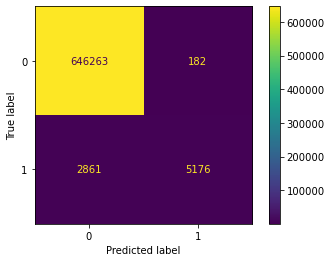

In [57]:
test_features_med = testing_merged_med[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                    'P(active)_1', 'P(active)_2', 'P(active)_3']]
test_targets = testing_merged_med['active']
test_pred_med = decision_tree.predict(test_features_med)
cm = confusion_matrix(test_targets, test_pred_med)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f"Test precision: {precision_score(test_targets, test_pred_med):.3f}")
print(f"Test recall: {recall_score(test_targets, test_pred_med):.3f}")

probs_med = decision_tree.predict_proba(test_features_med)
p_med, r_med, t_med = precision_recall_curve(test_targets, probs_med[:,1])

#### Predicting with cluster mean

Test precision: 0.837
Test recall: 0.782


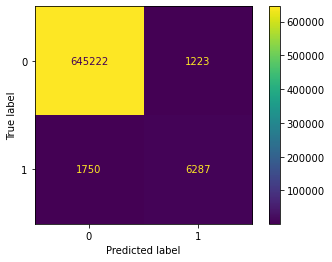

In [58]:
test_features_mean = testing_merged_mean[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                    'P(active)_1', 'P(active)_2', 'P(active)_3']]
test_pred_mean = decision_tree.predict(test_features_mean)
cm = confusion_matrix(test_targets, test_pred_mean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
print(f"Test precision: {precision_score(test_targets, test_pred_mean):.3f}")
print(f"Test recall: {recall_score(test_targets, test_pred_mean):.3f}")

probs_mean = decision_tree.predict_proba(test_features_mean)
p_mean, r_mean, t_mean = precision_recall_curve(test_targets, probs_mean[:,1])

#### Predicting with random value from assigned cluster

Test precision: 0.693
Test recall: 0.614


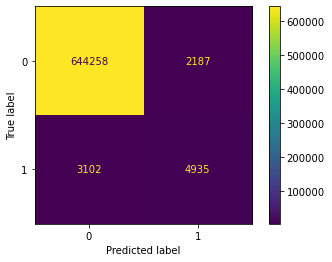

In [59]:
test_features_crand = testing_merged_crand[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                    'P(active)_1', 'P(active)_2', 'P(active)_3']]
test_pred_crand = decision_tree.predict(test_features_crand)
cm = confusion_matrix(test_targets, test_pred_crand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f"Test precision: {precision_score(test_targets, test_pred_crand):.3f}")
print(f"Test recall: {recall_score(test_targets, test_pred_crand):.3f}")

probs_crand = decision_tree.predict_proba(test_features_crand)
p_crand, r_crand, t_crand = precision_recall_curve(test_targets, probs_crand[:,1])

#### Predicting with value from nearest neighbor in cluster

Test precision: 0.865
Test recall: 0.845


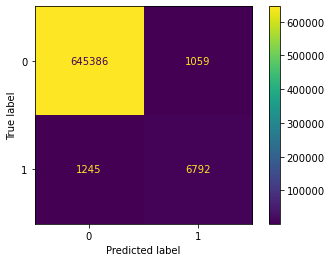

In [60]:
#fig, axs = plt.subplots(figsize=(8,5))
test_features_nn = testing_merged_nn[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                    'P(active)_1', 'P(active)_2', 'P(active)_3']]
test_pred_nn = decision_tree.predict(test_features_nn)
cm = confusion_matrix(test_targets, test_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
#im = axs.imshow(cm, cmap='gist_earth')
#fig.colorbar(im)
print(f"Test precision: {precision_score(test_targets, test_pred_nn):.3f}")
print(f"Test recall: {recall_score(test_targets, test_pred_nn):.3f}")

probs_nn = decision_tree.predict_proba(test_features_nn)
p_nn, r_nn, t_nn = precision_recall_curve(test_targets, probs_nn[:,1])

#### Predicting randomly

Test precision: 0.882
Test recall: 0.520


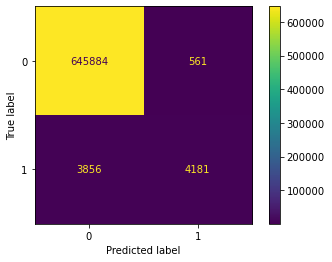

In [61]:
test_features_rand = testing_merged_rand[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                                    'P(active)_1', 'P(active)_2', 'P(active)_3']]
test_pred_rand = decision_tree.predict(test_features_rand)
cm = confusion_matrix(test_targets, test_pred_rand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(f"Test precision: {precision_score(test_targets, test_pred_rand):.3f}")
print(f"Test recall: {recall_score(test_targets, test_pred_rand):.3f}")

probs_rand = decision_tree.predict_proba(test_features_rand)
p_rand, r_rand, t_rand = precision_recall_curve(test_targets, probs_rand[:,1])

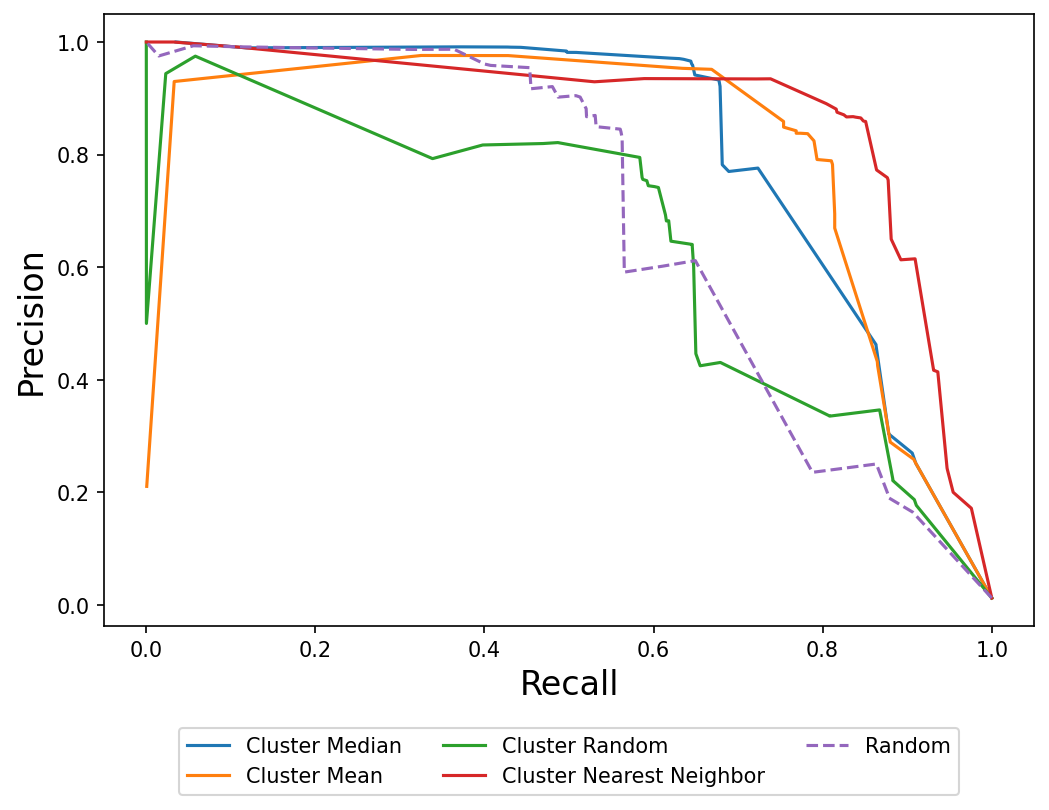

In [62]:
from sklearn.metrics import auc
sns.reset_orig()
fig, axs = plt.subplots(dpi=150, figsize=(8,6))
axs.plot(r_med[:-2], p_med[:-2], label=f'Cluster Median')
axs.plot(r_mean[:-2], p_mean[:-2], label=f'Cluster Mean')
axs.plot(r_crand, p_crand, label=f'Cluster Random')
axs.plot(r_nn, p_nn, label=f'Cluster Nearest Neighbor')
axs.plot(r_rand, p_rand, '--', label=f'Random')
axs.set_xlabel('Recall', fontsize=16)
axs.set_ylabel('Precision', fontsize=16)
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=False, ncol=3, facecolor='white')
#axs.set_title('Precision-Recall Curves for Decision Tree on Holdout Set')
#axs.legend(loc=(0, 0.2), facecolor='white')
#fig.savefig('../figures/prc_auc.png')
plt.show()

In [70]:
help()

Help on function auc in module sklearn.metrics._ranking:

auc(x, y)
    Compute Area Under the Curve (AUC) using the trapezoidal rule
    
    This is a general function, given points on a curve.  For computing the
    area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
    way to summarize a precision-recall curve, see
    :func:`average_precision_score`.
    
    Parameters
    ----------
    x : array, shape = [n]
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    y : array, shape = [n]
        y coordinates.
    
    Returns
    -------
    auc : float
    
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    >>> metrics.auc(fpr, tpr)
    0.75
    
    See also
    --------
    roc_auc_score : Compute the area under the R

In [63]:
pd.DataFrame({'Method': ['Cluster Median', 'Cluster Mean', 'Cluster Random', 'Cluster Nearest Neighbor', 'Random Guessing'],
              'AUC': [f'{auc(r_med, p_med):.3f}', f'{auc(r_mean, p_mean):.3f}', f'{auc(r_crand, p_crand):.3f}', f'{auc(r_nn, p_nn):.3f}', f'{auc(r_rand, p_rand):.3f}']})



,Method,AUC
0,Cluster Median,0.817
1,Cluster Mean,0.809
2,Cluster Random,0.643
3,Cluster Nearest Neighbor,0.874
4,Random Guessing,0.689


In [64]:
final_nn = test_features_nn.copy(deep=True)
final_nn['prob'] = probs_nn[:,1]
final_nn.sort_values(by='prob', ascending=False).head(10)

,bb1_Cluster,bb2_Cluster,bb3_Cluster,P(active)_1,P(active)_2,P(active)_3,prob
24878,2,2,2,0.184886,0.000115,0.994151,1.0
15648,2,2,2,0.408523,0.000115,0.983954,1.0
526,3,2,2,0.176671,0.000115,0.993674,1.0
525,3,2,2,0.261972,0.000115,0.993674,1.0
524,3,2,2,0.093267,0.000115,0.993674,1.0
523,3,2,2,0.125000,0.000115,0.993674,1.0
522,2,2,2,0.408523,0.000115,0.993674,1.0
521,2,2,2,0.132987,0.000115,0.993674,1.0
520,2,2,2,0.184886,0.000115,0.993674,1.0
519,2,2,2,0.170773,0.000115,0.993674,1.0


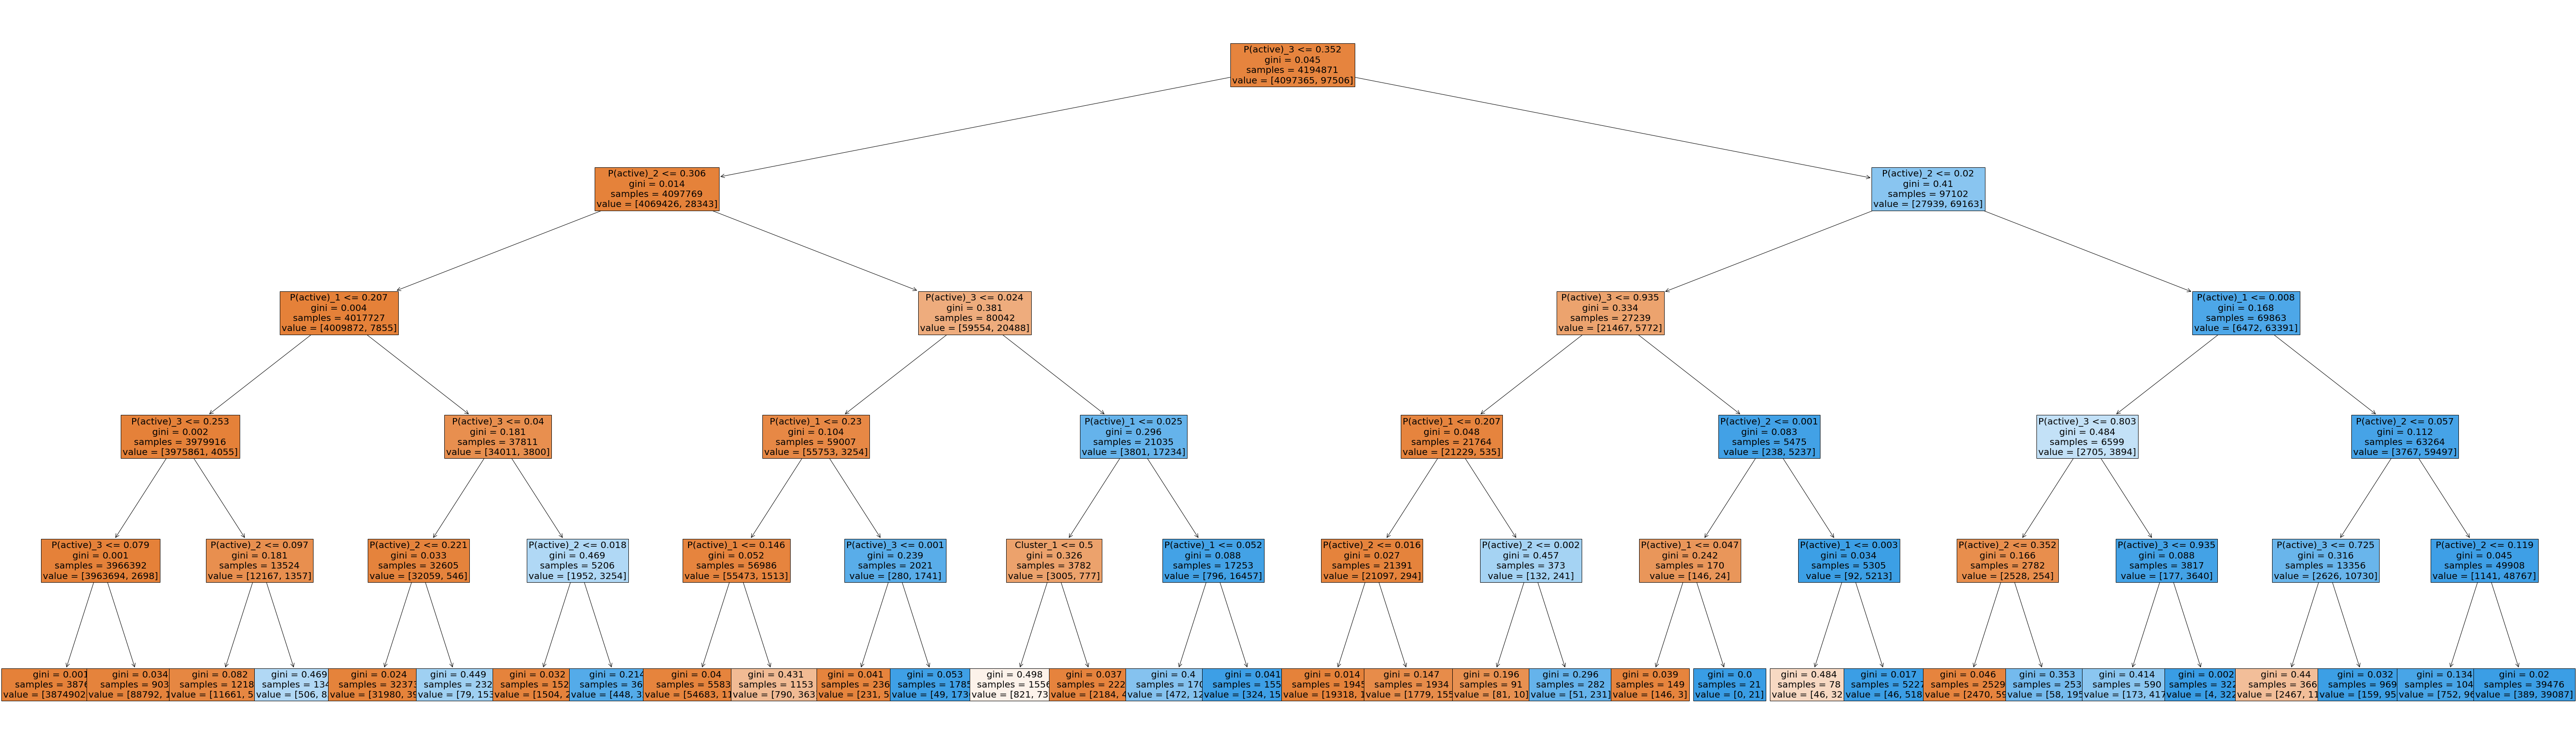

In [65]:
fig, axs = plt.subplots(figsize=(100,30))
f_names = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'P(active)_1', 'P(active)_2', 'P(active)_3']
tree.plot_tree(decision_tree, feature_names=f_names, filled=True, ax=axs, fontsize=20)
fig.savefig('tree.png')
#plt.show()

In [66]:
feat[0]

NameError: name 'feat' is not defined

In [ ]:
tab = pd.DataFrame()
tab = tab.append(pd.DataFrame(decision_tree.feature_importances_).T)
tab.columns =['Cluster_1', 'Cluster_2', 'Cluster_3', 'P(active)_1', 'P(active)_2', 'P(active)_3']
# feat = decision_tree.feature_importances_
# tab['Cluster_1'] = feat[0]
# tab['Cluster_2'] = feat[1]
# tab['Cluster_3'] = feat[2]
# tab['P(active)_1'] = feat[3]
# tab['P(active)_2'] = feat[4]
# tab['P(active)_3'] = feat[5]
tab

#### Case where P(active)3 is high but model appropriately labels compound as inactive 
(to show we are not overfitting just on the P(active) value at position 3)

In [ ]:
case1 = list(final_nn.loc[(final_crand['P(active)_3'] > 0.9) & (final_nn['prob'] < 0.4)].index)
testing_merged_nn.iloc[case1]

In [ ]:
final = testing_merged_nn.copy(deep=True)
final['prob'] = probs_nn[:,1]

tot = pd.merge(final, bb1_test_ans[['bb1', 'P(active)']], how='left', on='bb1')\
    .rename(columns={'P(active)': 'bb1_actual'})\
    .merge(bb2_test_ans[['bb2', 'P(active)']], how='left', on='bb2')\
    .rename(columns={'P(active)': 'bb2_actual'})\
    .merge(bb3_test_ans[['bb3', 'P(active)']], how='left', on='bb3')\
    .rename(columns={'P(active)': 'bb3_actual'})

In [ ]:
tot.to_csv('nn_model_pred.csv', index=False)

### What are the cases the model messes up?

In [ ]:
import rdkit
from rdkit import Chem

def draw_mol(row):
    bbs = [row['bb1'], row['bb2'], row['bb3']]
    label = [row['P(active)_1'], row['P(active)_2'], row['P(active)_3']]
    legends = [f'P(active): {x:.3f}' for x in label]
    mols = [Chem.MolFromSmiles(smi) for smi in bbs]
    return rdkit.Chem.Draw.MolsToGridImage(mols, legends=legends)

#### False Positives

In [ ]:
tot.iloc[24868]

In [ ]:
a = tot.loc[(tot['prob'] > 0.95) & (tot['active'] == 0)]
a

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(9,9))
axs[0][0].set_title('Test distribution')
axs[0][1].set_title('FP distribution')
axs[0][0].set_ylabel('P(active)_1', rotation=0, labelpad=60, fontsize=20)
axs[0][0].hist(final['P(active)_1'])
axs[0][1].hist(a['P(active)_1'])

axs[1][0].set_ylabel('P(active)_2', rotation=0, labelpad=60, fontsize=20)
axs[1][0].hist(final['P(active)_2'], color='orange')
axs[1][1].hist(a['P(active)_2'], color='orange')

axs[2][0].set_ylabel('P(active)_3', rotation=0, labelpad=60, fontsize=20)
axs[2][0].hist(final['P(active)_3'], color='green')
axs[2][1].hist(a['P(active)_3'], color='green')
plt.show()

#### False negatives

In [ ]:
b = tot.loc[(tot['prob'] < 0.05) & (tot['active'] == 1)]
b

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(9,9))
axs[0][0].set_title('Test distribution')
axs[0][1].set_title('FN distribution')
axs[0][0].set_ylabel('P(active)_1', rotation=0, labelpad=60, fontsize=20)
axs[0][0].hist(final['P(active)_1'])
axs[0][1].hist(b['P(active)_1'])

axs[1][0].set_ylabel('P(active)_2', rotation=0, labelpad=60, fontsize=20)
axs[1][0].hist(final['P(active)_2'], color='orange')
axs[1][1].hist(b['P(active)_2'], color='orange')

axs[2][0].set_ylabel('P(active)_3', rotation=0, labelpad=60, fontsize=20)
axs[2][0].hist(final['P(active)_3'], color='green')
axs[2][1].hist(b['P(active)_3'], color='green')
plt.show()